# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [3]:
from collections import Counter

import nltk
import numpy as np

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Define Batcher class 

In [5]:
import time
class Batcher:
    def __init__(self, batch_size=1024, vocab_size=4000, window_size=2):
        self.__stopwords = nltk.corpus.stopwords.words('english')
        self.__word2Ind = None
        self.__ind2Word = None
        self.__vocab = None
        
        self.__batch_size = batch_size
        self.__vocab_size = vocab_size - 1
        self.__window_size = window_size
        
    def __read_corpus(self, path):
        with open(path) as txt:
            corpus = txt.read()
        return corpus
        
    def __make_vocab(self, corpus):
        word_counts = Counter(corpus)
        if len(word_counts) < self.__vocab_size:
            self.__vocab_size = len(word_counts) - 1
            
        self.__vocab = set([x[0] for x in word_counts.most_common(self.__vocab_size)])
        
    def __make_idxs(self):
        self.__word2Ind = {'<UNK>':self.__vocab_size}
        self.__ind2Word = {self.__vocab_size:'<UNK>'}
        for i, word in enumerate(self.__vocab):
            self.__word2Ind[word] = i
            self.__ind2Word[i] = word
            
    def translate(self, indices):
        return [self.__ind2Word[idx] for idx in indices]
    
    def get_vocab(self):
        return set(self.__vocab)
    
    def get_vocab_size(self):
        return int(self.__vocab_size)
    
    def word2Ind(self, words):
        return [self.__word2Ind[word] for word in words]
    
    def make_batches(self, path, method='skip-gram'):
        corpus = self.__read_corpus(path)
        corpus = corpus.replace('\n', ' ').lower()
        corpus = corpus.split(' ')
        self.__make_vocab(corpus)
        self.__make_idxs()
        
        X, y = [], []
        padding_corpus = ['<PAD>' for i in range(self.__window_size)]   
        corpus = padding_corpus + corpus + padding_corpus.copy()
        for i in range(self.__window_size, len(corpus) - self.__window_size):
            central_idx, context_idx = None, []
            central, context = corpus[i], (corpus[i-self.__window_size:i] + corpus[i+1:i+self.__window_size+1])
            for word in context:
                if word in self.__vocab:
                    context_idx.append(self.__word2Ind[word])
                else:
                    context_idx.append(self.__vocab_size)
                
            if central in self.__vocab:
                central_idx = self.__word2Ind[central]
            else:
                central_idx = self.__vocab_size
            
            if method == 'cbow':
                X.append(np.array(context_idx))
                y.append(central_idx)
            elif method == 'skip-gram':
                X.append(central_idx)
                y.append(context_idx)
                
            if (i - self.__window_size + 1) % self.__batch_size == 0:
                yield np.array(X), np.array(y)
                X, y = [], []
        yield np.array(X), np.array(y)

## Model architecture

In [6]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, window_size, hidden_size):
        super(CBOW, self).__init__()
        
        self.__window_size = window_size
        self.__embd_size = embd_size
        
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((-1, self.__window_size * 2, self.__embd_size))
        embedded = torch.mean(embedded, dim=1)
        hid = self.linear1(embedded)
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs
    
    def get_embeds(self, inputs):
        embeds = self.embeddings(inputs).view((-1, self.__embd_size))
        return embeds
    
#     def most_similar(self, label, batcher, n=10):
#         target = torch.LongTensor(batcher.word2Ind([label])[0])
#         F.cosine_similarity()

## Define some useful functions

In [7]:
def plot_losses(losses, val_losees):
    fig = pylab.figure(figsize=(20, 10))
    pylab.plot(val_losses, label='val_loss')
    pylab.plot(losses, label='train_loss')
    pylab.grid()
    pylab.legend(loc='upper right')
    pylab.xlabel('epoch')
    pylab.ylabel('loss')
    pylab.title('loss over epochs')
    
def plot_wordspace(data, batcher):
    fig = pylab.figure(figsize=(18, 15))
    pylab.title('wordspace')
    pylab.scatter(data[:, 0], data[:, 1])
    pylab.grid()
    for i, idx in enumerate(plot_sample):
        pylab.annotate(batcher.translate([idx])[0], (data[i, 0], data[i, 1]))

## Choose device to train on 

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device: ' + str(device))

device: cuda


# text8 

## Train loop 

In [16]:
window_size = 2
vocab_size = 4000
batch_size = 1024
hidden_size = 128
embd_size = 300
learning_rate = 0.001
n_epoch = 20
path = '/kaggle/input/text-data/text8'
test_path = '/kaggle/input/texttest/text8'

batcher = Batcher(batch_size=batch_size, vocab_size=vocab_size, window_size=window_size)

losses, val_losses = [], []
loss_fn = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, window_size, hidden_size)
print(model)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print('PREPARING BATCHES...')
batches = [[context, target] for context, target in batcher.make_batches(path, method='cbow')]
print('DONE\n')

print('TRAINING MODEL...')
if str(device) == 'cuda':
    model = model.to('cuda')

for epoch in range(n_epoch):
    print('EPOCH {}'.format(int(epoch + 1)))
    train_loss, val_loss = .0, .0
    progress = 0
    
    train_batches, test_batches = train_test_split(batches, test_size=.1, shuffle=True)
    for i, data in enumerate(train_batches):
        context, target = data
        
        percent = np.floor((i + 1 ) / len(batches) * 100)
        if percent > progress:
            print('    batch {}%'.format(int(percent)))
            progress = percent
            
        context_var = autograd.Variable(torch.LongTensor(context))
        target_var = autograd.Variable(torch.LongTensor(target))
        model.zero_grad()
        
        if str(device) == 'cuda':
            context_var, target_var = context_var.to('cuda'), target_var.to('cuda')
        
        log_probs = model(context_var)
        loss = loss_fn(log_probs, target_var)

        back = loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print('VALIDATING...')
    for i, data in enumerate(test_batches):
        context, target = data 
        context_var = autograd.Variable(torch.LongTensor(context))
        target_var = autograd.Variable(torch.LongTensor(target))
        model.zero_grad()  
        if str(device) == 'cuda':
            context_var, target_var = context_var.to('cuda'), target_var.to('cuda')
        
        log_probs = model(context_var)
        loss = loss_fn(log_probs, target_var)
        val_loss += loss.item()
        
    train_loss /= len(train_batches)
    val_loss /= len(test_batches)
    print('TRAIN LOSS: {:.5f}, VALIDATION LOSS: {:.5f}\n\n'.format(train_loss, val_loss))
    losses.append(train_loss)
    val_losses.append(val_loss)

CBOW(
  (embeddings): Embedding(4000, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4000, bias=True)
)
PREPARING BATCHES...
DONE

TRAINING MODEL...
EPOCH 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
 

    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%
    batch 75%
    batch 76%
    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 5.28126, VALIDATION LOSS: 5.26516


EPOCH 8
    batch 1%
    batch 2%
    batch 3%
    batch

    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%
    batch 75%
    batch 76%
    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 5.18627, VALIDATION LOSS: 5.17917


EPOCH 14
    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%


    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 5.13895, VALIDATION LOSS: 5.12061


EPOCH 20
    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%


### Plot loss 

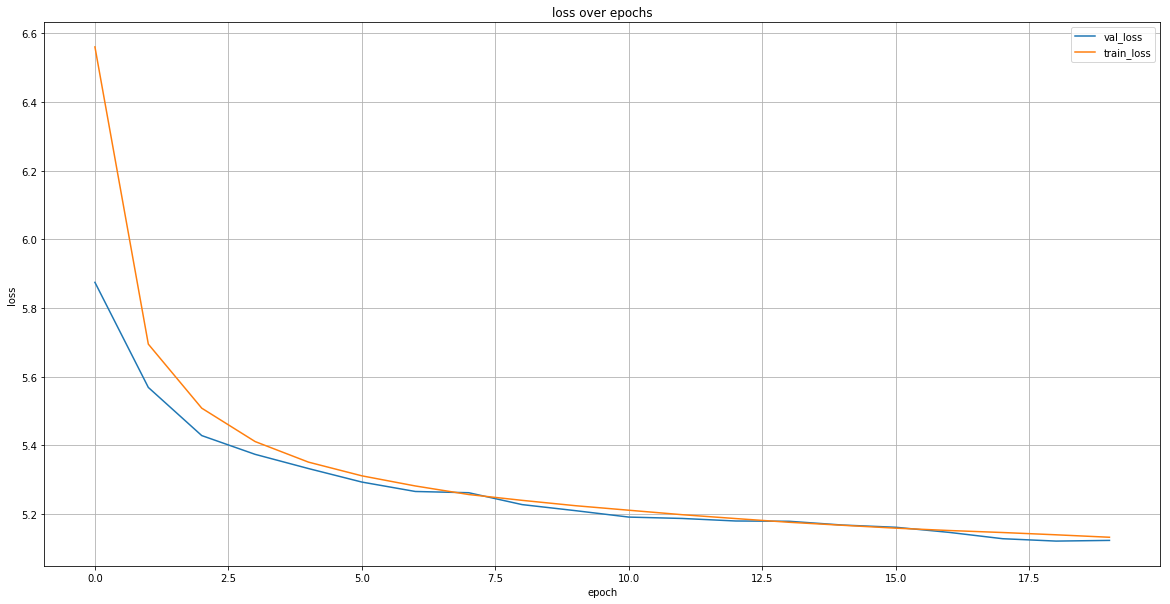

In [17]:
plot_losses(losses, val_losses)

## Few examples 

In [83]:
vocab = batcher.get_vocab()
sample = np.random.choice(batcher.word2Ind(vocab), 1)
sample_tensor = torch.LongTensor(sample)
if str(device) == 'cuda':
    sample_tensor = sample_tensor.to('cuda')
print(batcher.translate(sample)[0], model.get_embeds(sample_tensor))

warmer tensor([[-0.1809,  0.9892, -1.8726, -0.5862,  2.2856, -1.1839,  1.2306, -0.1369,
         -0.2539,  0.3004, -0.0435,  0.0966,  0.5875,  1.5408,  2.5139,  1.1927,
          1.1320,  0.4723,  0.6056,  0.4054, -0.5602,  0.5567,  0.1177,  1.0759,
         -0.6948,  0.4991,  0.2995, -0.2956, -0.9025, -0.6982,  0.4016,  1.7296,
         -0.0049,  1.5319, -0.4266, -1.0169,  1.9450, -1.2403,  0.2817, -0.8326,
         -1.0992, -1.2334,  1.0769,  0.3847,  0.4134,  0.8364, -0.7576,  1.5516,
          1.0030,  0.6547,  2.0107,  2.0172, -0.7973,  0.6455,  0.1712, -0.3821,
         -0.8267,  0.2649, -1.3631,  0.1804, -0.9226, -1.2809,  0.4529,  0.7504,
          1.7110, -1.5141,  0.6693, -1.9979, -1.6063, -1.8006,  1.4920,  1.8383,
         -0.9501, -1.3654, -0.1653,  1.0085, -0.8138, -0.0961,  0.1903,  0.0818,
         -1.1814, -0.0356,  1.9313, -0.4924,  0.1392,  0.0305,  0.3135,  0.5278,
         -0.9021, -1.9802, -0.5771, -0.1905, -1.2018, -0.4628, -2.1195, -1.3571,
         -0.7574,  0.

In [84]:
sample = np.random.choice(batcher.word2Ind(vocab), 1)
sample_tensor = torch.LongTensor(sample)
if str(device) == 'cuda':
    sample_tensor = sample_tensor.to('cuda')
print(batcher.translate(sample)[0], model.get_embeds(sample_tensor))

seriously tensor([[ 3.8007e-01,  1.4494e+00,  8.6835e-01, -1.7522e-02, -2.1666e+00,
         -1.7097e-01, -7.7454e-01,  5.3759e-01, -7.5774e-02, -5.4024e-01,
          3.1954e-01,  1.0017e+00, -9.8255e-01,  1.2716e+00,  7.1058e-01,
         -3.9192e-01, -1.1754e+00,  3.4116e-01,  7.7044e-01, -9.7034e-01,
          6.6205e-01,  5.1805e-01, -4.7531e-01, -1.6747e+00, -1.6888e+00,
          8.1881e-01,  5.7405e-01,  6.2134e-01, -1.4410e+00, -5.3967e-01,
          3.1159e+00, -1.7275e+00,  1.3638e+00,  5.8172e-01,  1.4111e+00,
         -6.3232e-01,  1.8488e+00,  6.1489e-01,  5.3070e-02, -2.0404e+00,
          1.8858e+00, -5.9315e-01,  6.9299e-01,  9.5154e-01,  7.3883e-01,
         -5.3458e-01, -9.7360e-02,  3.7183e-01, -3.2253e-01, -6.4772e-01,
          6.3451e-01,  6.6171e-01,  1.8259e+00, -7.8259e-01,  4.3198e-01,
          2.5155e-02,  1.7899e-02,  7.8457e-01, -2.2548e+00, -1.0380e-01,
          9.6946e-01, -1.3316e+00, -1.2350e+00,  8.3882e-01,  1.1582e-01,
          3.4298e-01, -2.295

## Plot wordspace 

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plot_sample = np.random.choice(list(range(vocab_size)), 500)
plot_tensor = torch.LongTensor(plot_sample)
if str(device) == 'cuda':
    plot_tensor = plot_tensor.to('cuda')
numpy_embeds = model.get_embeds(plot_tensor).detach().cpu()

pca_transformed = StandardScaler().fit_transform( PCA(n_components=2).fit_transform(numpy_embeds) )
tsne_transformed = TSNE(metric='cosine').fit_transform(numpy_embeds)

#### PCA Visualisation 

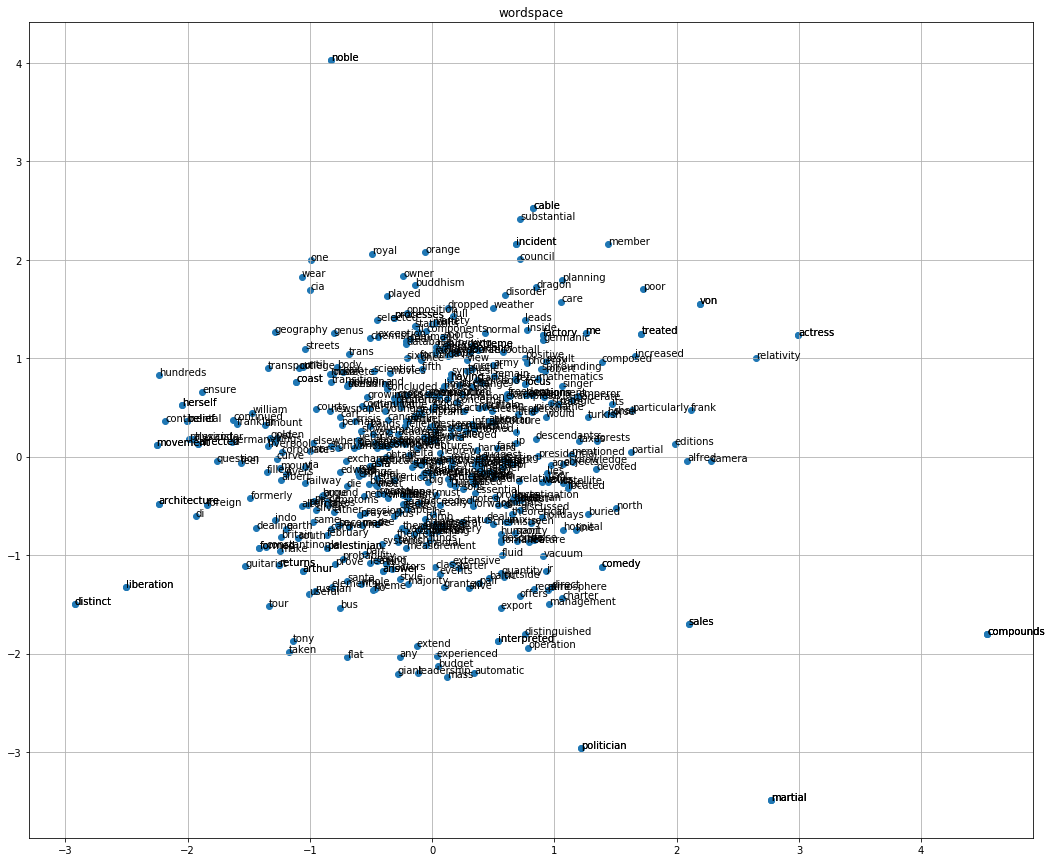

In [40]:
plot_wordspace(pca_transformed, batcher)

#### TSNE visualisation 

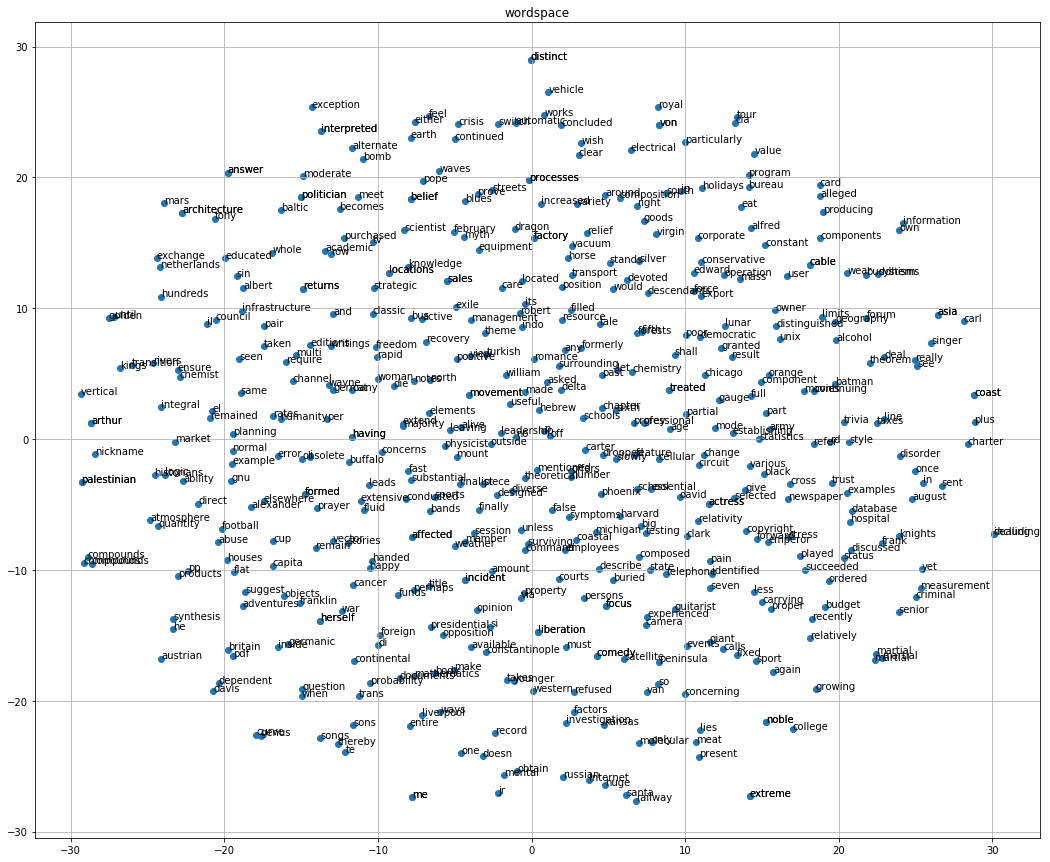

In [41]:
plot_wordspace(tsne_transformed, batcher)

# Try intrinsic dataset 

## Train loop 

In [42]:
window_size = 1
vocab_size = 1000
batch_size = 16
hidden_size = 128
embd_size = 300
learning_rate = 0.001
n_epoch = 30
path = '/kaggle/input/intrinsic/questions-words.txt'

batcher = Batcher(batch_size=batch_size, vocab_size=vocab_size, window_size=window_size)

losses, val_losses = [], []
loss_fn = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, window_size, hidden_size)
print(model)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print('PREPARING BATCHES...')
batches = [[context, target] for context, target in batcher.make_batches(path, method='cbow')]
print('DONE\n')

print('TRAINING MODEL...')
if str(device) == 'cuda':
    model = model.to('cuda')

for epoch in range(n_epoch):
    print('EPOCH {}'.format(int(epoch + 1)))
    train_loss, val_loss = .0, .0
    progress = 0
    
    train_batches, test_batches = train_test_split(batches, test_size=.1, shuffle=True)
    for i, data in enumerate(train_batches):
        context, target = data
        
        percent = np.floor((i + 1 ) / len(batches) * 100)
        if percent > progress:
            print('    batch {}%'.format(int(percent)))
            progress = percent
            
        context_var = autograd.Variable(torch.LongTensor(context))
        target_var = autograd.Variable(torch.LongTensor(target))
        model.zero_grad()
        
        if str(device) == 'cuda':
            context_var, target_var = context_var.to('cuda'), target_var.to('cuda')
        
        log_probs = model(context_var)
        loss = loss_fn(log_probs, target_var)

        back = loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print('VALIDATING...')
    for i, data in enumerate(test_batches):
        context, target = data 
        context_var = autograd.Variable(torch.LongTensor(context))
        target_var = autograd.Variable(torch.LongTensor(target))
        model.zero_grad()  
        if str(device) == 'cuda':
            context_var, target_var = context_var.to('cuda'), target_var.to('cuda')
        
        log_probs = model(context_var)
        loss = loss_fn(log_probs, target_var)
        val_loss += loss.item()
        
    train_loss /= len(train_batches)
    val_loss /= len(test_batches)
    print('TRAIN LOSS: {:.5f}, VALIDATION LOSS: {:.5f}\n\n'.format(train_loss, val_loss))
    losses.append(train_loss)
    val_losses.append(val_loss)

CBOW(
  (embeddings): Embedding(4000, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4000, bias=True)
)
PREPARING BATCHES...
DONE

TRAINING MODEL...
EPOCH 1
    batch 1%
    batch 2%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%

    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%
    batch 75%
    batch 76%
    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 7.07447, VALIDATION LOSS: 6.92393


EPOCH 8
    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%

    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%
    batch 75%
    batch 76%
    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 4.68481, VALIDATION LOSS: 4.50494


EPOCH 14
    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%


    batch 84%
    batch 85%
    batch 86%
    batch 87%
    batch 88%
    batch 89%
VALIDATING...
TRAIN LOSS: 2.24447, VALIDATION LOSS: 2.11354


EPOCH 20
    batch 1%
    batch 2%
    batch 3%
    batch 4%
    batch 5%
    batch 6%
    batch 7%
    batch 8%
    batch 9%
    batch 10%
    batch 11%
    batch 12%
    batch 13%
    batch 14%
    batch 15%
    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%


    batch 16%
    batch 17%
    batch 18%
    batch 19%
    batch 20%
    batch 21%
    batch 22%
    batch 23%
    batch 24%
    batch 25%
    batch 26%
    batch 27%
    batch 28%
    batch 29%
    batch 30%
    batch 31%
    batch 32%
    batch 33%
    batch 34%
    batch 35%
    batch 36%
    batch 37%
    batch 38%
    batch 39%
    batch 40%
    batch 41%
    batch 42%
    batch 43%
    batch 44%
    batch 45%
    batch 46%
    batch 47%
    batch 48%
    batch 49%
    batch 50%
    batch 51%
    batch 52%
    batch 53%
    batch 54%
    batch 55%
    batch 56%
    batch 57%
    batch 58%
    batch 59%
    batch 60%
    batch 61%
    batch 62%
    batch 63%
    batch 64%
    batch 65%
    batch 66%
    batch 67%
    batch 68%
    batch 69%
    batch 70%
    batch 71%
    batch 72%
    batch 73%
    batch 74%
    batch 75%
    batch 76%
    batch 77%
    batch 78%
    batch 79%
    batch 80%
    batch 81%
    batch 82%
    batch 83%
    batch 84%
    batch 85%
    batch 86%
    ba

### Plot loss 

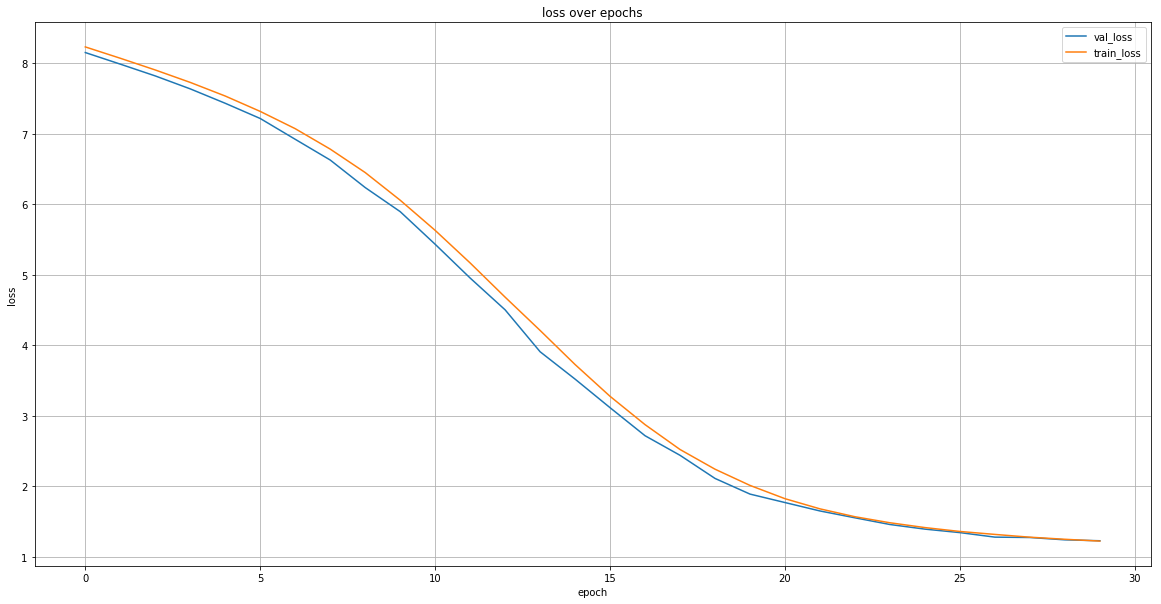

In [43]:
plot_losses(losses, val_losses)

### Plot wordspace 

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plot_sample = np.random.choice(list(range(batcher.get_vocab_size())), 500)
plot_tensor = torch.LongTensor(plot_sample)
if str(device) == 'cuda':
    plot_tensor = plot_tensor.to('cuda')
numpy_embeds = model.get_embeds(plot_tensor).detach().cpu()

pca_transformed = StandardScaler().fit_transform( PCA(n_components=2).fit_transform(numpy_embeds) )
tsne_transformed = TSNE(metric='cosine').fit_transform(numpy_embeds)

#### PCA

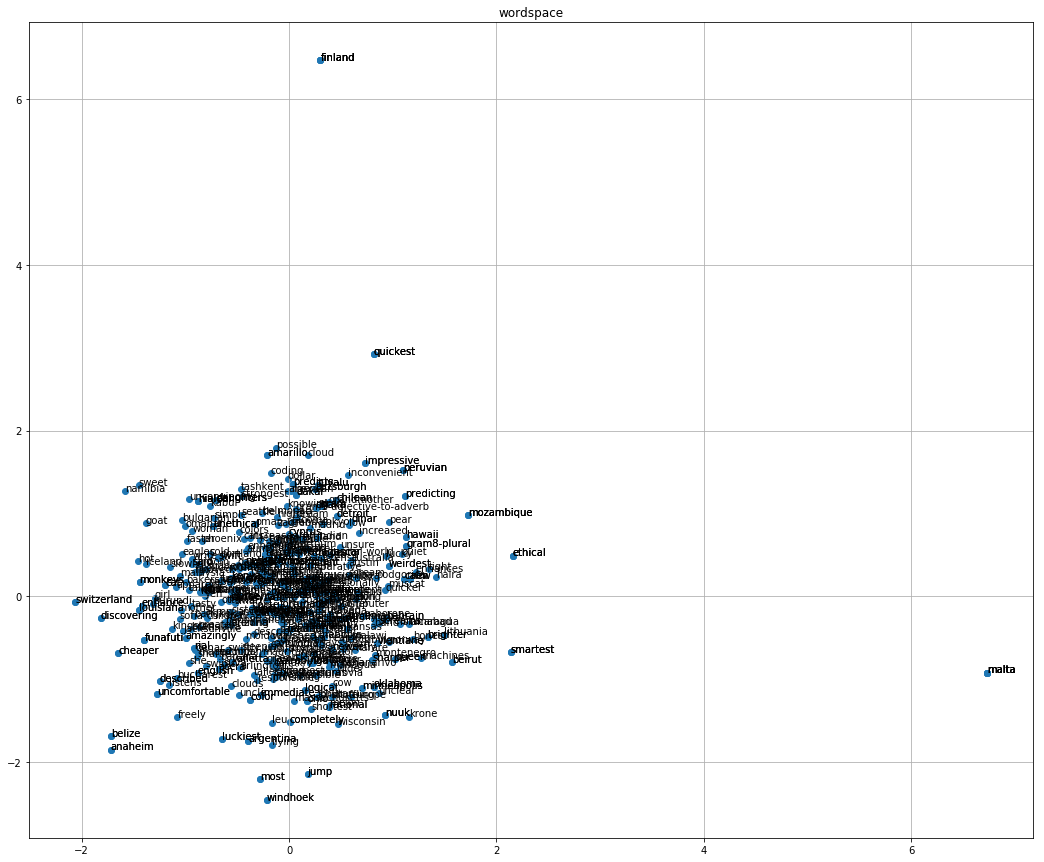

In [48]:
plot_wordspace(pca_transformed, batcher)

#### TSNE 

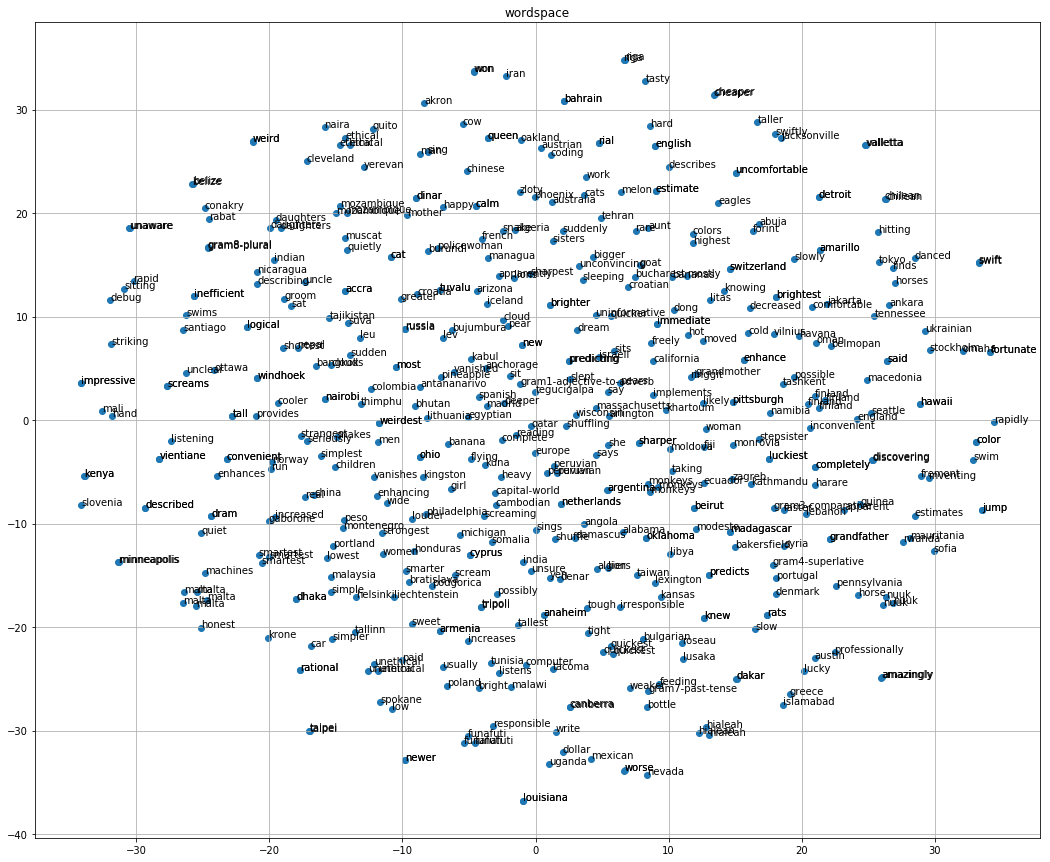

In [49]:
plot_wordspace(tsne_transformed, batcher)

### Validate model 

**greece:athens :: iraq:baghdad**

In [81]:
def check(context, batcher):
    idx = model(autograd.Variable(torch.LongTensor(batcher.word2Ind(context))).to('cuda')).argmax().item()
    return batcher.translate([idx])[0]

In [82]:
check(['greece', 'baghdad'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'athens'

In [85]:
check(['greece', 'iraq'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'athens'

**known:unknown :: possible:impossible**

In [86]:
check(['known', 'possible'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'unknown'

In [87]:
check(['unknown', 'impossible'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'possible'

**Austria:Austrian :: Denmark:Danish**

In [90]:
check(['austria', 'danish'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'austrian'

**knowing:knew :: moving:moved**

In [91]:
check(['knew', 'moving'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'knowing'

In [95]:
check(['knowing', 'moving'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'moved'

**road:roads :: machine:machines**

In [96]:
check(['road', 'machine'], batcher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'machines'